# [E-12 다음에 볼 영화 예측하기]

시간이 부족해서 깔끔하게 정리하지 못한점,, 미리 사과 드립니다.

## 1. 데이터 불러오기

In [2]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

In [27]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


추천 시스템을 구축할때 가장 먼저 확인해 볼 것은 유저수와 아이템 수이다.

In [28]:
print(data['UserId'].nunique(), data['ItemId'].nunique())

6040 3706


유저 수는 6040명, 아이템 숫자는 3706개이다.

## 2. 데이터 전처리

### 2.1 Session ID
#### shift()를 이용한 시간차 계산

### 2.1 Session ID

In [29]:
# UserId와 Time을 기준으로 새로운 데이터프레임 생성
df = data.groupby(['UserId', 'Time'])['ItemId'].count().reset_index()
df.reset_index(inplace=True)
df

,index,UserId,Time,ItemId
0,0,1,978300019,1
1,1,1,978300055,3
2,2,1,978300103,1
3,3,1,978300172,1
4,4,1,978300275,1
...,...,...,...,...
471158,471158,6040,997454398,1
471159,471159,6040,997454429,1
471160,471160,6040,997454464,2
471161,471161,6040,997454486,1


In [30]:
# SessionId 컬럼 추가
data = pd.merge(data, df, on=['UserId', 'Time'])
data.drop(columns='ItemId_y', inplace=True)
data.columns = ['UserId', 'ItemId', 'Rating', 'Time', 'SessionId']
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161


### 2.3 Session Length

In [31]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
0         1
1         3
2         1
3         1
4         1
         ..
471158    1
471159    1
471160    2
471161    1
471162    1
Length: 471163, dtype: int64

In [32]:
session_length.median(), session_length.mean()

(2.0, 2.1228513274599234)

In [33]:
session_length.min(), session_length.max()

(1, 30)

In [34]:
session_length.quantile(0.999)

10.0

In [35]:
long_session = session_length[session_length==30].index[0]
data[data['SessionId']==long_session]

,UserId,ItemId,Rating,Time,SessionId
112347,731,3044,4,975528402,55117
112348,731,1455,3,975528402,55117
112349,731,1639,5,975528402,55117
112350,731,3244,4,975528402,55117
112351,731,1656,2,975528402,55117
112352,731,3426,4,975528402,55117
112353,731,1829,2,975528402,55117
112354,731,2675,4,975528402,55117
112355,731,802,3,975528402,55117
112356,731,803,5,975528402,55117


In [36]:

length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1    0.480048
2    0.713936
3    0.847350
4    0.919684
5    0.958639
6    0.979132
7    0.989772
8    0.994989
9    0.997604
dtype: float64

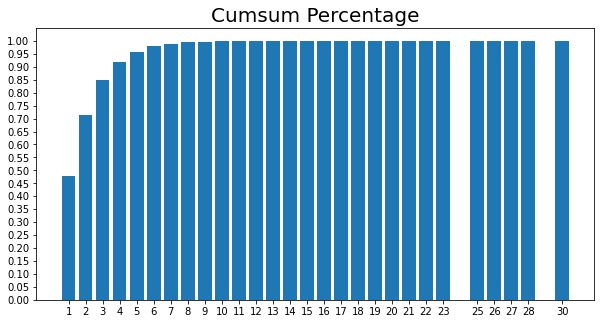

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(x=length_percent_cumsum.index,
        height=length_percent_cumsum)
plt.xticks(length_percent_cumsum.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage', size=20)
plt.show()

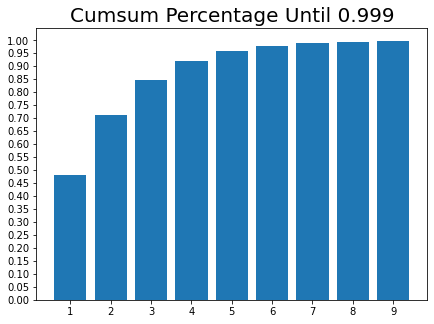

In [38]:
plt.figure(figsize=(7, 5))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999)
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### 2.4 Session Time

In [39]:
from datetime import datetime
data['Time'] = data['Time'].map(lambda x: datetime.fromtimestamp(x))
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [40]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [42]:
month_ago = latest - dt.timedelta(days=365)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,UserId,ItemId,Rating,Time,SessionId
5333,36,1387,5,2002-03-12 03:46:59,2791
5334,36,1201,4,2002-03-12 03:46:59,2791
5335,36,1291,5,2002-03-12 03:47:16,2792
5336,36,2167,5,2002-03-12 03:48:25,2793
5337,36,2951,4,2002-03-12 03:48:25,2793
...,...,...,...,...,...
992789,5996,3835,3,2002-04-29 20:46:24,468261
992790,5996,2422,3,2002-04-29 20:47:05,468262
992791,5996,168,3,2002-09-03 13:12:26,468263
992792,5996,339,4,2002-10-07 13:24:39,468264


### 2.4 Data Cleansing

In [43]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [44]:
data = cleanse_recursive(data, shortest=2, least_click=20) # 형준님, 진아님 감사합니다(least_click 올리기)
data

,UserId,ItemId,Rating,Time,SessionId
5333,36,1387,5,2002-03-12 03:46:59,2791
5334,36,1201,4,2002-03-12 03:46:59,2791
5336,36,2167,5,2002-03-12 03:48:25,2793
5338,36,2115,5,2002-03-12 03:48:25,2793
5363,36,1266,5,2002-12-22 08:18:29,2815
...,...,...,...,...,...
992742,5996,368,5,2002-04-29 19:52:08,468231
992744,5996,2247,4,2002-04-29 19:54:04,468232
992745,5996,552,4,2002-04-29 19:54:04,468232
992767,5996,786,3,2002-04-29 20:08:45,468245


### 2.5 Train/Valid/Test split

In [45]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [46]:
tr, test = split_by_date(data, n_days=30)
tr, val = split_by_date(tr, n_days=70)

In [47]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [48]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 3544
	 Sessions: 1340
	 Items: 536
	 First Time : 2002-03-01 21:16:50
	 Last Time : 2002-11-17 18:11:38

* valid Set Stats Info
	 Events: 744
	 Sessions: 287
	 Items: 384
	 First Time : 2002-11-17 20:56:25
	 Last Time : 2003-01-26 18:45:41

* test Set Stats Info
	 Events: 361
	 Sessions: 150
	 Items: 258
	 First Time : 2003-01-28 18:41:15
	 Last Time : 2003-02-27 17:45:48



In [49]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [52]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## 3. Data pipeline

### 3.1 Session-Parllel Mini-Batches 

Session의 길이는 매우 짧은 것 들이 대부분이지만 긴 것도 있다.  
그래서 이 세션들을 데이터 샘플 하나로 보고 mini-batch를 구성하게 되면 젤 긴 세션의 연산이 끝날 때까지 짧은 세션들이 기다려야한다.  
그래서 Session-Parlle Mini-Batches를 쓰는데, 이름처럼 Session이 끝날 때까지 기다리지 않고 병렬적으로 계산한다.  
아래의 그림처럼 session2가 끝났다면 다음으로 session4가 시작한다.  
이렇게 구성했을 때 mini-batch의 shape는 (3,1,1)이 되고 RNN cell의 ste가 1개로만 이루어 진다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/input2.max-800x600.png)

### 3.2 Session Dataset

In [53]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [54]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,item_idx
5333,36,1387,5,2002-03-12 03:46:59,2791,0
5334,36,1201,4,2002-03-12 03:46:59,2791,1
5336,36,2167,5,2002-03-12 03:48:25,2793,2
5338,36,2115,5,2002-03-12 03:48:25,2793,3
9754,65,2628,4,2002-05-27 02:58:30,4875,4
9755,65,1210,4,2002-05-27 02:58:30,4875,5
13360,104,3155,2,2002-03-13 21:41:27,6468,6
13361,104,2707,3,2002-03-13 21:41:27,6468,7
13365,104,3005,3,2002-03-13 21:41:50,6470,8
13366,104,3298,3,2002-03-13 21:41:50,6470,9


In [55]:
tr_dataset.click_offsets

array([   0,    2,    4, ..., 3540, 3542, 3544], dtype=int32)

In [56]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 1337, 1338, 1339])

### 3.2 Session Data Loader

In [57]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [58]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionId,item_idx
5333,36,1387,5,2002-03-12 03:46:59,2791,0
5334,36,1201,4,2002-03-12 03:46:59,2791,1
5336,36,2167,5,2002-03-12 03:48:25,2793,2
5338,36,2115,5,2002-03-12 03:48:25,2793,3
9754,65,2628,4,2002-05-27 02:58:30,4875,4
9755,65,1210,4,2002-05-27 02:58:30,4875,5
13360,104,3155,2,2002-03-13 21:41:27,6468,6
13361,104,2707,3,2002-03-13 21:41:27,6468,7
13365,104,3005,3,2002-03-13 21:41:50,6470,8
13366,104,3298,3,2002-03-13 21:41:50,6470,9


In [59]:
iter_ex = iter(tr_data_loader)

In [60]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [0 2 4 6]
Label Item Idx are :       [1 3 5 7]
Previous Masked Input Idx are []


## 4. Modeling

In [61]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [62]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [63]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [86]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=15, k=20)

In [87]:
model = create_model(args)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(128, 1, 536)]           0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    88200     
_________________________________________________________________
dropout_5 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_5 (Dense)              (128, 536)                27336     
Total params: 115,536
Trainable params: 115,536
Non-trainable params: 0
_________________________________________________________________


## 5. Train

In [88]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

성능 평가는 recall과 mrr을 이용한다.  
recall은 우리가 많이 봤던 것이고 mrr은 무엇인가?!!  
[MRR (mean reciprocal rank)](https://ang-love-chang.tistory.com/22)


In [89]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

	 - Recall@20 epoch 1: 0.054688
	 - MRR@20    epoch 1: 0.016495



Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

	 - Recall@20 epoch 2: 0.093750
	 - MRR@20    epoch 2: 0.024395



Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

	 - Recall@20 epoch 3: 0.109375
	 - MRR@20    epoch 3: 0.025309



Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

	 - Recall@20 epoch 4: 0.101562
	 - MRR@20    epoch 4: 0.021115



Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

	 - Recall@20 epoch 5: 0.097656
	 - MRR@20    epoch 5: 0.018763



Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

	 - Recall@20 epoch 6: 0.093750
	 - MRR@20    epoch 6: 0.014735



Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

	 - Recall@20 epoch 7: 0.078125
	 - MRR@20    epoch 7: 0.012029



Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

	 - Recall@20 epoch 8: 0.089844
	 - MRR@20    epoch 8: 0.012821



Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

	 - Recall@20 epoch 9: 0.082031
	 - MRR@20    epoch 9: 0.011664



Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

	 - Recall@20 epoch 10: 0.089844
	 - MRR@20    epoch 10: 0.011406



Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

	 - Recall@20 epoch 11: 0.093750
	 - MRR@20    epoch 11: 0.014403



Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

	 - Recall@20 epoch 12: 0.101562
	 - MRR@20    epoch 12: 0.015289



Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

	 - Recall@20 epoch 13: 0.101562
	 - MRR@20    epoch 13: 0.016102



Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

	 - Recall@20 epoch 14: 0.105469
	 - MRR@20    epoch 14: 0.016720



Evaluation:  67%|██████▋   | 2/3 [00:01<00:00,  1.30it/s]

	 - Recall@20 epoch 15: 0.105469
	 - MRR@20    epoch 15: 0.018427



## 6. Test

In [90]:

def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

	 - Recall@20: 0.078125
	 - MRR@20: 0.018024



---
# Session id 재 정의 후 다시,,

## 1. 데이터 로드

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
from datetime import datetime
data['Time'] = data['Time'].map(lambda x: datetime.fromtimestamp(x))
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


## 2. 데이터 전처리

In [4]:
data['delta'] = (data['Time'] - data['Time'].shift()).fillna(pd.Timedelta(seconds=0))
data

,UserId,ItemId,Rating,Time,delta
31,1,3186,4,2000-12-31 22:00:19,0 days 00:00:00
22,1,1270,5,2000-12-31 22:00:55,0 days 00:00:36
27,1,1721,4,2000-12-31 22:00:55,0 days 00:00:00
37,1,1022,5,2000-12-31 22:00:55,0 days 00:00:00
24,1,2340,3,2000-12-31 22:01:43,0 days 00:00:48
...,...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29,0 days 00:00:31
999988,6040,1921,4,2001-08-10 14:41:04,0 days 00:00:35
1000172,6040,1784,3,2001-08-10 14:41:04,0 days 00:00:00
1000167,6040,161,3,2001-08-10 14:41:26,0 days 00:00:22


#### session id 만들기

In [24]:
from datetime import timedelta
session_id = 0
exuser = data.UserId[0]
a = timedelta(minutes=30)

def get_session_id(x) :
    global session_id
    global exuser 
    if (exuser != x['UserId']) or (x['delta'] > a):
        session_id +=1
    exuser = x['UserId']
    return session_id

In [25]:
data['SessionId'] = data.apply(get_session_id, axis=1)
data

,UserId,ItemId,Rating,Time,delta,SessionId
31,1,3186,4,2000-12-31 22:00:19,0 days 00:00:00,0
22,1,1270,5,2000-12-31 22:00:55,0 days 00:00:36,0
27,1,1721,4,2000-12-31 22:00:55,0 days 00:00:00,0
37,1,1022,5,2000-12-31 22:00:55,0 days 00:00:00,0
24,1,2340,3,2000-12-31 22:01:43,0 days 00:00:48,0
...,...,...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29,0 days 00:00:31,25161
999988,6040,1921,4,2001-08-10 14:41:04,0 days 00:00:35,25161
1000172,6040,1784,3,2001-08-10 14:41:04,0 days 00:00:00,25161
1000167,6040,161,3,2001-08-10 14:41:26,0 days 00:00:22,25161


함수명과 변수명이 똑같아서 자꾸 오류가 발생했었는데 괜히 막 함수 내용 고치고 있었다,,,ㅋㅋ 

### 2.2 Session Length

In [26]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
0         40
1         13
2        129
3         51
4         21
        ... 
25158      7
25159     14
25160      1
25161     21
25162      1
Length: 25163, dtype: int64

In [27]:
session_length.median(), session_length.mean()

(6.0, 39.74919524698963)

In [28]:
session_length.min(), session_length.max()

(1, 1193)

In [29]:
session_length.quantile(0.999)

764.3520000000135

평균 세션의 길이는 39 이고, 99.9% 세션은 길이가 764이하 이다.  
그러나 최대 세션은 1193으로 아주 길다.. 한번 데이터를 살펴보자

In [33]:
long_session = session_length[session_length==1193].index[0]
data[data['SessionId']==long_session]

,UserId,ItemId,Rating,Time,delta,SessionId
637775,3841,1480,3,2000-08-11 11:57:39,0 days 21:58:11,16445
637808,3841,969,5,2000-08-11 11:57:39,0 days 00:00:00,16445
638269,3841,858,5,2000-08-11 11:57:39,0 days 00:00:00,16445
638716,3841,2019,5,2000-08-11 11:57:39,0 days 00:00:00,16445
638733,3841,1221,5,2000-08-11 11:57:39,0 days 00:00:00,16445
...,...,...,...,...,...,...
638038,3841,3806,5,2000-08-11 14:23:11,0 days 00:00:00,16445
638243,3841,1379,2,2000-08-11 14:23:11,0 days 00:00:00,16445
638459,3841,1928,4,2000-08-11 14:23:11,0 days 00:00:00,16445
638710,3841,2016,3,2000-08-11 14:23:11,0 days 00:00:00,16445


이 사람은 거의 2시간 반동안 엄첨 짧게 많은 것 클릭했다. 평점을 주는건데 이렇게 빠르게 많이 할 수있는가,,?  
이상하다고 생각해서 너무 긴 세션은 없애 주기로한다. (cleansing)

In [31]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1      0.273378
2      0.373882
3      0.424115
4      0.456543
5      0.483726
         ...   
729    0.998808
735    0.998848
744    0.998887
746    0.998927
761    0.998967
Length: 532, dtype: float64

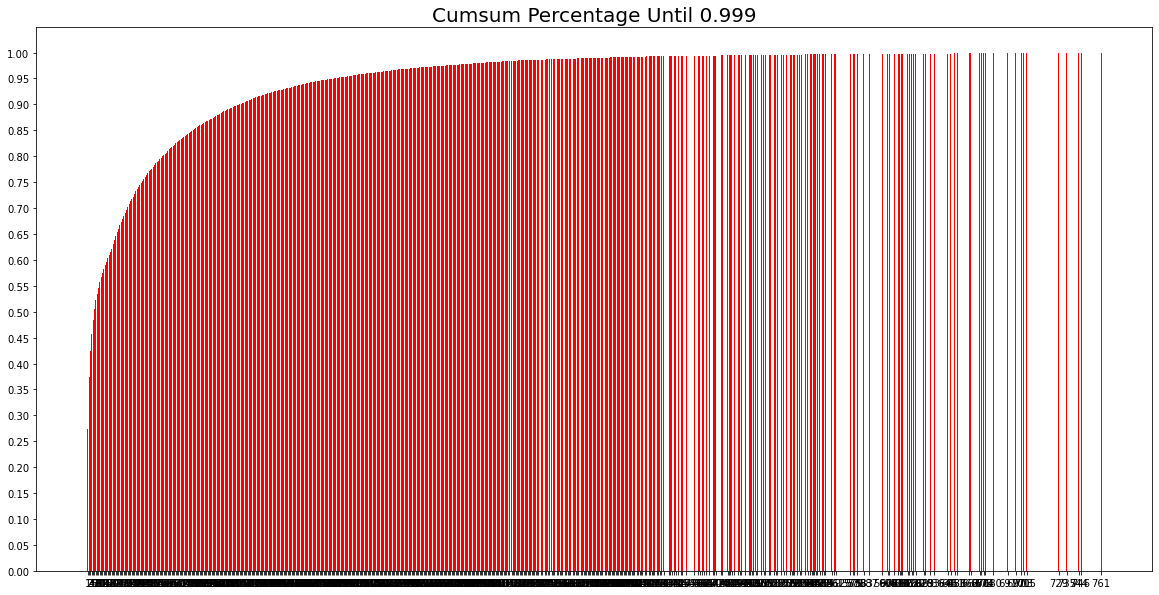

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### 2.3 Session Time

In [34]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


약 3년치의 데이터가 있었다. 나는 1년치 데이터를 사용하려고 한다,